In [1]:
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cProfile
import pstats
%load_ext line_profiler

--------

### Set the number of resources

In [4]:
L = 40

### Define the ancestral phenotype (traits vector)

In [5]:
anc_phenotype = utils.random_matrix(shape=(1, L), mode='binomial')

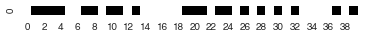

In [6]:
viz.matrix_plot(anc_phenotype)

### Define the system biochemistry (trait/resource interactions)

In [7]:
J = utils.random_matrix((L, L), 'tikhonov_sigmoid')

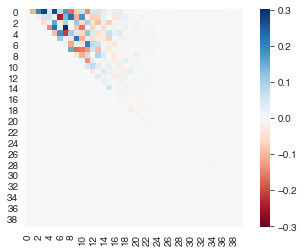

In [8]:
viz.matrix_plot(J)

In [9]:
np.sum(J)

1.505359526752857

### Parameterize and instantiate the Consumer-Resource System

In [10]:
anc_system = ConsumerResourceSystem(sigma=anc_phenotype, 
                                    b=1, 
                                    k=1e10,
                                    c=0.1, chi=0.5, J=J, 
                                    mu=1e-10,
                                    resource_consumption_mode='fast_resource_eq',
                                    resource_inflow_mode='none',
                                    threshold_min_rel_abundance=1e-6,
                                    N_init=1, R_init=1)

In [11]:
print(anc_system.type_set._sigma.alloc)

(1, 40)


In [12]:
print(anc_system.mutant_set._sigma.alloc)

(40, 40)


In [13]:
print(anc_system.type_set.energy_costs)

[9.67221633]


In [14]:
print(anc_system.type_set.type_ids)

[3130132704803494601]


In [15]:
print(anc_system.type_set.parent_indices)

[None]


In [16]:
print(anc_system.type_set.lineage_ids)

['1']


In [17]:
print(anc_system.type_set.phylogeny)

{'1': {}}


In [18]:
# stop

### Simulate dynamics

In [19]:
# just to pre-compile the dynamics njit function
# anc_system.dynamics(*((0,) + (np.zeros(L+L+1),) + anc_system.get_params()))

In [20]:
# anc_system.run(T=1000)

In [21]:
# %lprun -f anc_system.dynamics anc_system.run(T=1000)
# %lprun -f anc_system.handle_mutation_event anc_system.run(T=1000)

In [22]:
profiler = cProfile.Profile()
# %lprun -f anc_system.dynamics profiler.runcall(anc_system.run)
# %lprun -f ConsumerResourceSystem.growth_rate profile.runcall(anc_system.run)
# %lprun -f anc_system.event_low_abundance profiler.runcall(anc_system.run)
# %lprun -f TypeSet.add_type profiler.runcall(anc_system.run)
# %lprun -f TypeSet.generate_mutant_set profiler.runcall(anc_system.run)

%lprun -f anc_system.run profiler.runcall(anc_system.run)

Timer unit: 1e-06 s

Total time: 331.205 s
File: /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py
Function: run at line 227

Line #      Hits         Time  Per Hit   % Time  Line Contents
   227                                               def run(self, T=1e5, dt=None, integration_method='default'):
   228                                           
   229         1         30.0     30.0      0.0          t_start   = self.t
   230         1          2.0      2.0      0.0          t_elapsed = 0
   231                                           
   232                                                   # print(self.N_series, self.N_series.shape)
   233                                           
   234                                                   # print( np.zeros(shape=(self.N_series.shape[0], int(T/dt if dt is not None else T/0.1))) )
   235                                           
   236                                  

In [23]:
ps = pstats.Stats(profiler)
ps.sort_stats('cumtime')
ps.print_stats()

         16926957 function calls (16926944 primitive calls) in 332.027 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    4.672    4.672  332.027  332.027 /Users/ryan/Dropbox/Projects/ResearchProjects/eco-evo-crm/ecoevocrm/src/ecoevocrm/consumer_resource_system.py:227(run)
    11841    4.569    0.000  208.759    0.018 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/ivp.py:156(solve_ivp)
    76218    0.598    0.000  183.646    0.002 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py:159(step)
    76218    1.057    0.000  183.048    0.002 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/lsoda.py:140(_step_impl)
    76218    3.808    0.000  181.852    0.002 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ode.py:1338(run)
   203812    0.489    0.000  177.914    0.001 /usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/base.py:136(fun)
   203812    0.421    0.00

### Visualize results

In [24]:
anc_system.reorder_types()

In [25]:
type_colors = viz.color_types_by_phylogeny(anc_system.type_set, apply_palette_depth=1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(anc_system, ax=ax, type_colors=type_colors)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_phenotype, ax=ax)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(3, 12))
# viz.matrix_plot(anc_system.type_set.sigma, ax=ax)

In [ ]:
# anc_system.extant_type_indices

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 12))
viz.matrix_plot(anc_system.get_extant_type_set().sigma, ax=ax)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(3, 12))
# viz.matrix_plot(anc_system.extant_mutant_set.sigma, ax=ax)

In [ ]:
viz.Lstar_types_plot(anc_system)

In [ ]:
N_end = anc_system.N_series[:,-1]
np.count_nonzero((N_end > 0) & (N_end < 1e4))

In [ ]:
a = (anc_system.N_series > 0).argmax(axis=1)
n = []
for t_idx in range(anc_system.t_series.shape[0]):
    n.append(np.count_nonzero(a <= t_idx)) 
plt.plot(anc_system.t_series, n)
plt.plot(anc_system.t_series, (anc_system.N_series > 0).sum(axis=0))

In [ ]:
plt.hist(anc_system.N_series[(anc_system.N_series[:,-1]>0)&(anc_system.N_series[:,-1]<1e4),-1], bins=100)
# plt.xlim((0,100))
plt.show()

In [ ]:
r = ConsumerResourceSystem.growth_rate(anc_system.N()[:, np.newaxis], anc_system.R(), anc_system.type_set.sigma, anc_system.type_set.b, anc_system.type_set.k, anc_system.type_set.eta, anc_system.type_set.l, anc_system.type_set.g, anc_system.type_set.energy_costs, anc_system.resource_set.omega, anc_system.resource_consumption_mode)

plt.hist(r[anc_system.N() > 0] , bins=100)
plt.show()

In [ ]:
s = r - np.mean(r[anc_system.N() > 0])

plt.hist(s[anc_system.N() > 0] , bins=100)
plt.show()

In [ ]:
r_lowabd = r[(anc_system.N() > 0) & (anc_system.N() < 1e4)]

plt.hist(r_lowabd, bins=100)
plt.axvline(0, color='k', alpha=0.3, ls='--')
plt.show()

In [ ]:
s_lowabd = r[(anc_system.N() > 0) & (anc_system.N() < 1e4)] - np.mean(r[r > 0])

plt.hist(s_lowabd, bins=100)
plt.axvline(0, color='k', alpha=0.3, ls='--')
plt.show()

In [ ]:
plt.scatter(anc_system.N()[anc_system.N() > 0], r[anc_system.N() > 0])
plt.axhline(0, color='k', alpha=0.3, ls='--')
plt.xscale('log')
plt.show()

In [ ]:
plt.scatter(anc_system.N()[anc_system.N() > 0], s[anc_system.N() > 0])
plt.axhline(0, color='k', alpha=0.3, ls='--')
plt.xscale('log')
plt.show()

In [ ]:
anc_system.type_set.sigma.shape

In [ ]:
a = np.where(anc_system.N_series > 0)

In [ ]:
anc_system.N()/np.sum(anc_system.N())

In [ ]:
anc_system.get_extant_types()


In [ ]:
1e3/1e10

In [ ]:
anc_system.type_set.mu.shape

In [ ]:
anc_system.t_series.shape

In [ ]:
anc_system.N_series.shape

In [ ]:
viz.matrix_plot(anc_system.type_set.sigma)

In [ ]:
viz.matrix_plot(anc_system.extant_mutant_set.sigma)

In [ ]:
anc_system._t_series.alloc

In [ ]:
anc_system.t_series

In [ ]:
anc_system.t

In [ ]:
anc_system._N_series.alloc

In [ ]:
anc_system.N_series

In [ ]:
anc_system.N

In [ ]:
anc_system.N_series.shape

In [ ]:
anc_system._N_series._arr

In [ ]:
anc_system._N_series._arr[0]

In [ ]:
anc_system.type_set._sigma.shape

In [ ]:
anc_system.type_set.sigma.shape

In [ ]:
anc_system.mutant_set.sigma.shape